# CWT Algorithm

This notebook tutorial shows how to work with `CWT` algorithm for detecting gamma-ray sources.

You can find the [docs here](http://docs.gammapy.org/en/latest/api/gammapy.detect.CWT.html#gammapy.detect.CWT)
and [source code on GitHub here](https://github.com/gammapy/gammapy/blob/master/gammapy/detect/cwt.py) for better understanding how the algorithm is constructed. 

## Setup

On this section we just import some packages that can be used (or maybe not) in this tutorial. You can also see the versions of the packages in the outputs below and notice that this notebook was written on Python 2.7. Don't worry about that because the code is also Python 3 compatible. 

In [1]:
# Render our plots inline
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
import sys
import numpy as np
import scipy as sp
print('Python version: ' + sys.version)
print('Numpy version: ' + np.__version__)
print('Scipy version: ' + sp.__version__)

Python version: 3.5.3 (default, Jan 21 2017, 15:44:58) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
Numpy version: 1.12.1
Scipy version: 0.19.0


## CWT Algorithm. PlayGround

First of all we import the data which should be analysied.

In [3]:
import os
from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from gammapy.image import SkyImage

filename = '$GAMMAPY_EXTRA/datasets/fermi_survey/all.fits.gz'

image = SkyImage.read(filename=filename, hdu='COUNTS')
background = SkyImage.read(filename=filename, hdu='BACKGROUND')

size = Angle([10, 20], 'deg')
image = image.cutout(position=image.center, size=size)
background = background.cutout(position=background.center, size=size)

data = dict(image=image, background=background)

(<matplotlib.figure.Figure at 0x10bc0fa90>,
 None)

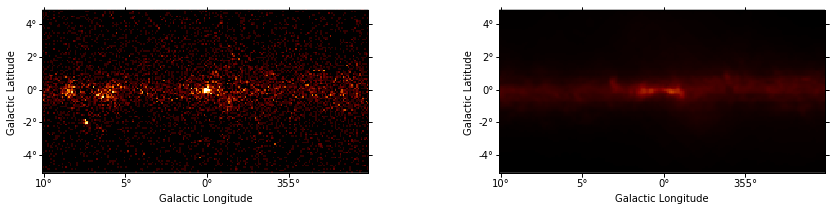

In [4]:
fig = plt.figure(figsize=(15, 3))

ax = fig.add_subplot(121, projection=data['image'].wcs)
data['image'].plot(vmax=10, ax=ax, fig=fig)

ax = fig.add_subplot(122, projection=data['background'].wcs)
data['background'].plot(vmax=10, ax=ax, fig=fig)

Let's explore how CWT works. At first define parameters of the algorithm.  An imperative parameter is kernels (`detect.CWTKernels` object). So we should create it.

In [5]:
# Input parameters for CWTKernels
N_SCALE = 2  # Number of scales considered.
MIN_SCALE = 6.  # First scale used.
STEP_SCALE = 1.3  # Base scaling factor.

In [6]:
from gammapy.detect import CWTKernels

cwt_kernels = CWTKernels(
    n_scale=N_SCALE,
    min_scale=MIN_SCALE,
    step_scale=STEP_SCALE,
)
print(cwt_kernels.info_table)

                     Name                            Source     
---------------------------------------------- -----------------
                              Number of scales                 2
                                 Minimal scale               6.0
                                    Step scale               1.3
                                        Scales       [ 6.   7.8]
                          Kernels approx width                83
                            Kernels approx sum    0.999915334516
                            Kernels approx max  0.00154790470972
              Kernels base width for 6.0 scale                63
                Kernels base sum for 6.0 scale 3.01663209714e-05
                Kernels base max for 6.0 scale 8.59947060958e-05
Kernels base width for 7.800000000000001 scale                83
  Kernels base sum for 7.800000000000001 scale  1.4561412133e-05
  Kernels base max for 7.800000000000001 scale 3.01091369685e-05


Other parameters are optional, in this demonstration define them all.

In [7]:
MAX_ITER = 10  # The maximum number of iterations of the CWT algorithm.
TOL = 1e-5  # Tolerance for stopping criterion.
SIGNIFICANCE_THRESHOLD = 2.  # Measure of statistical significance.
SIGNIFICANCE_ISLAND_THRESHOLD = None # Measure is used for cleaning of isolated pixel islands.
REMOVE_ISOLATED = True  # If True, isolated pixels will be removed.
KEEP_HISTORY = True # If you want to save images of all the iterations

Let's start to analyse input data. Import Logging module to see how the algorithm works during data analysis.

In [8]:
from gammapy.detect import CWT
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
cwt = CWT(
    kernels=cwt_kernels, 
    tol=TOL, 
    significance_threshold=SIGNIFICANCE_THRESHOLD, 
    significance_island_threshold=SIGNIFICANCE_ISLAND_THRESHOLD, 
    remove_isolated=REMOVE_ISOLATED, 
    keep_history=KEEP_HISTORY,
)

In order to the algorithm was able to analyze source images, you need to convert them to a special format, i.e. create an CWTData object. Do this.

In [9]:
from gammapy.detect import CWTKernels, CWTData

cwt_data = CWTData(
    counts=data['image'],
    background=data['background'],
    n_scale=N_SCALE,
) 

In [10]:
# Start the algorithm  
cwt.analyze(cwt_data)

## Results of analysis

Look at the results of CWT algorithm. Print all the images.

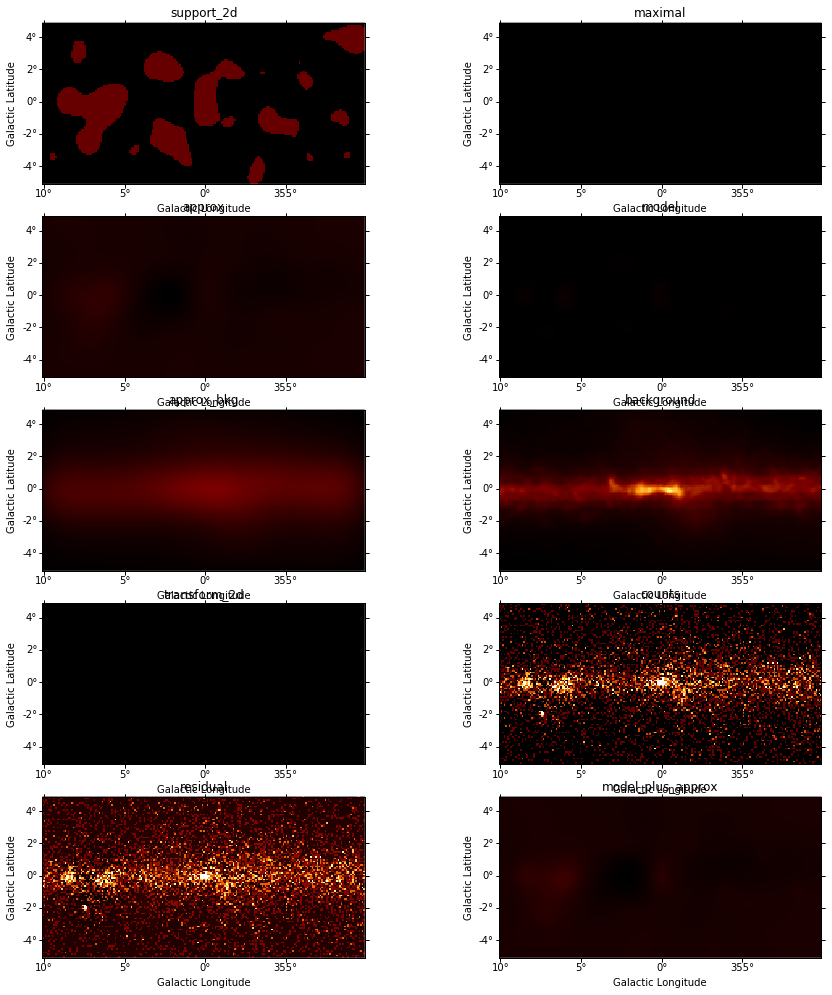

In [11]:
PLOT_VALUE_MAX = 5
FIG_SIZE = (15, 35)

fig = plt.figure(figsize=FIG_SIZE)
images = cwt_data.images()
for index, (name, image) in enumerate(images.items()): 
    ax = fig.add_subplot(len(images), 2, index + 1, projection=image.wcs)
    image.plot(vmax=PLOT_VALUE_MAX, fig=fig, ax=ax)
    plt.title(name) # Maybe add a Name in SkyImage.plots?

As you can see in the implementation of CWT above, it has the parameter `keep_history`. If you set to it `True`-value, it means that CWT would save all the images from iterations. Algorithm keeps images of only last CWT start.  Let's do this in the demonstration.

In [12]:
history = cwt.history
print('Number of iterations: {0}'.format(len(history) - 1)) # -1 because CWT save start images too

Number of iterations: 10


Let's have a look, what's happening with images after the first iteration.

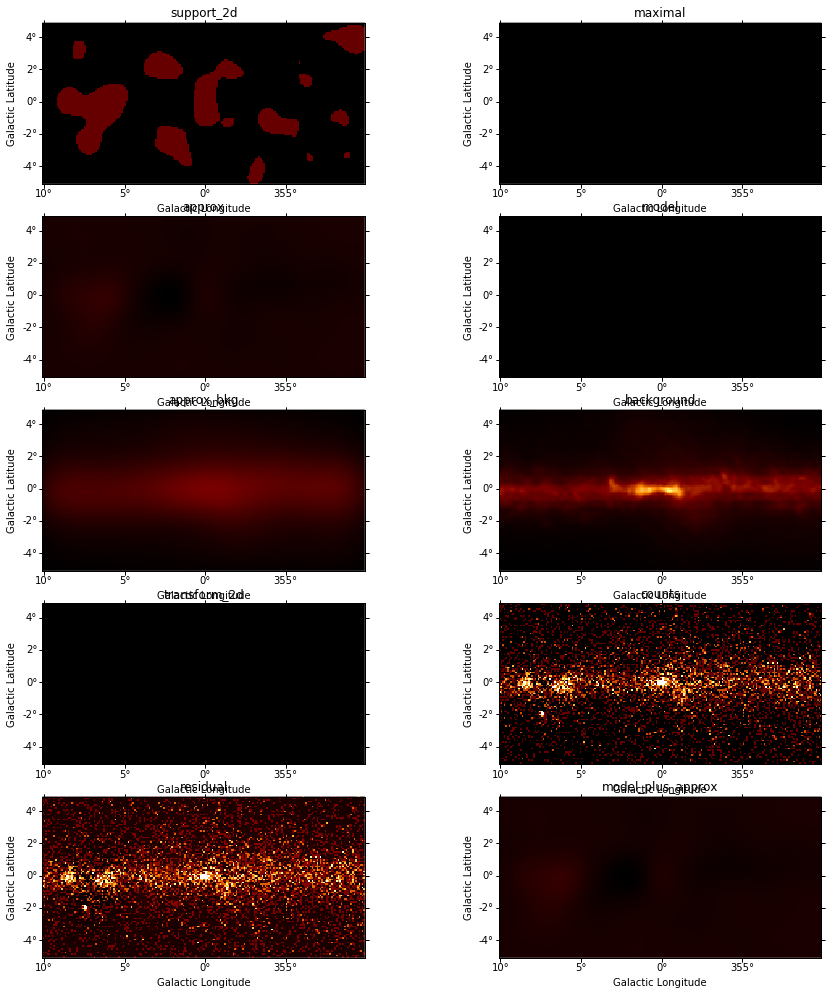

In [13]:
N_ITER = 1
assert 0 < N_ITER < len(history)
data_iter = history[N_ITER]

fig = plt.figure(figsize=FIG_SIZE)
images_iter = data_iter.images()
for index, (name, image) in enumerate(images_iter.items()): 
    ax = fig.add_subplot(len(images_iter), 2, index + 1, projection=image.wcs)
    image.plot(vmax=PLOT_VALUE_MAX, fig=fig, ax=ax)
    plt.title(name) # Maybe add a Name in SkyImage.plots?

You can get the information about the one particular image in that way: 

In [14]:
print(data_iter.image_info(name='approx_bkg'))

 Metrics        Source    
---------- ---------------
      Name      approx_bkg
     Shape        2D image
  Variance 0.0800090238573
      Mean  0.423057647467
 Max value   1.21632073897
 Min value 0.0322794972041
Sum values   8461.15294934


You can also get the information about cubes. Or information about all the data. 

In [15]:
print(data_iter.cube_info(name='support', per_scale=True))

Scale power  Metrics     Source  
----------- ---------- ----------
          1       Name    support
         --      Shape   2D image
         --   Variance 0.10030839
         --       Mean     0.1131
         --  Max value       True
         --  Min value      False
         -- Sum values       2262
          2       Name    support
         --      Shape   2D image
         --   Variance   0.122551
         --       Mean      0.143
         --  Max value       True
         --  Min value      False
         -- Sum values       2860


In [16]:
print(data_iter.cube_info(name='support', per_scale=False))

 Metrics      Source   
---------- ------------
      Name      support
     Shape      3D cube
  Variance 0.1116531975
      Mean      0.12805
 Max value         True
 Min value        False
Sum values         5122


Also you can see the difference betwen the iterations in that way:

In [17]:
history = cwt.history # get list of 'CWTData' objects
difference = history[1] - history[0] # get new `CWTData` obj, let's work with them

In [18]:
print(difference.cube_info('support'))

 Metrics      Source   
---------- ------------
      Name      support
     Shape      3D cube
  Variance 0.1116531975
      Mean      0.12805
 Max value         True
 Min value        False
Sum values         5122


In [19]:
difference.info_table.show_in_notebook()

idx,Name,Shape,Variance,Mean,Max value,Min value,Sum values
0,support_2d,2D image,0.13944375,0.1675,1.0,0.0,3350.0
1,maximal,2D image,1.27064959705e-06,0.000343964663935,0.0111684652858,0.0,6.8792932787
2,approx,2D image,0.00402266659823,-0.00804611016778,0.271338582375,-0.251765384164,-160.922203356
3,model,2D image,2.46869845878e-06,0.000455676406189,0.0154327993377,0.0,9.11352812377
4,approx_bkg,2D image,0.0800090238573,0.423057647467,1.21632073897,0.0322794972041,8461.15294934
5,background,2D image,0.165220253511,0.453299561273,3.91485793084,0.0938217013732,9065.99122547
6,transform_2d,2D image,2.46869845878e-06,0.000455676406189,0.0154327993377,0.0,9.11352812377
7,counts,2D image,0.6672141975,0.44445,24.0,0.0,8889.0
8,residual,2D image,0.666300092318,0.452040433762,23.9435547617,-0.283584814746,9040.80867523
9,model_plus_approx,2D image,0.00411546702714,-0.00759043376159,0.285133242591,-0.251765384164,-151.808675232


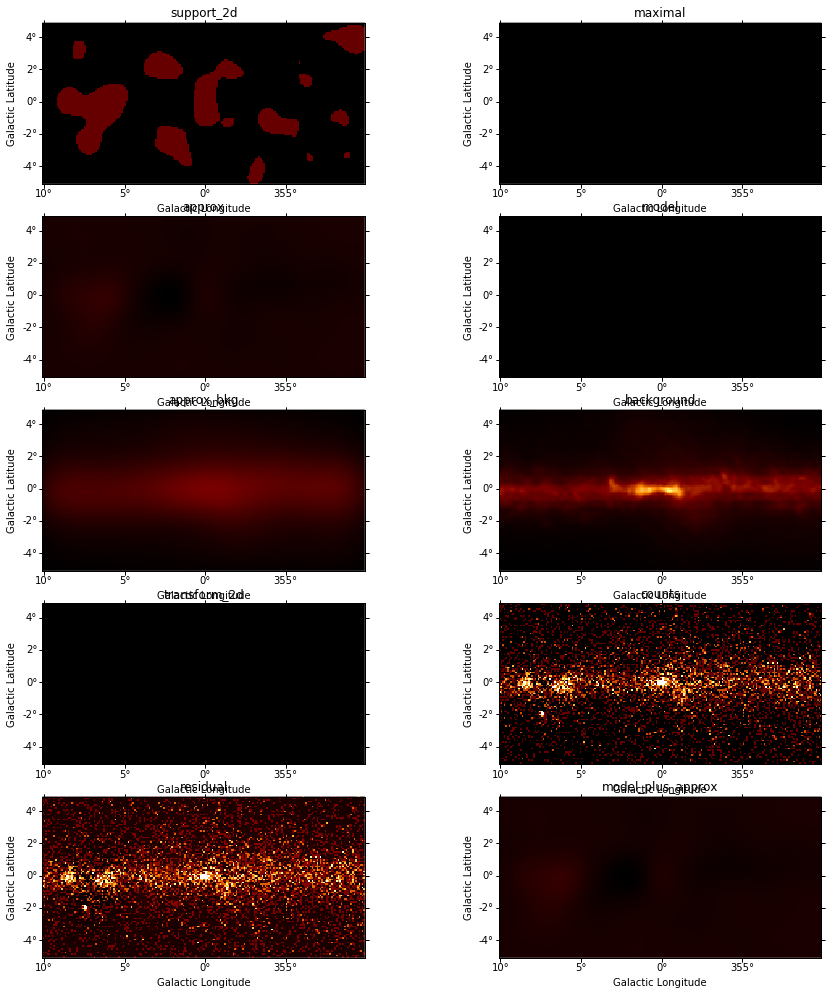

In [20]:
fig = plt.figure(figsize=FIG_SIZE)
images_diff = difference.images()
for index, (name, image) in enumerate(images_diff.items()): 
    ax = fig.add_subplot(len(images_diff), 2, index + 1, projection=image.wcs)
    image.plot(vmax=PLOT_VALUE_MAX, fig=fig, ax=ax)
    plt.title(name) # Maybe add a Name in SkyImage.plots?

You can save the results if you want

In [21]:
# cwt_data.write('test-cwt.fits', True)